<h1><font color="#113D68" size=5>TINTOlib: Converting Tidy Data into Synthetic Images</font></h1>>

<h1><font color="#113D68" size=5>Template Binary Classification problem with a Hibryd Networks (CNN+MLP)</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
<font color="#113D68" size=3>Raúl García-Castro</font><br>
<font color="#113D68" size=3>Jiayun Liu</font><br>

</div>

---

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
More information about [Manuel Castillo-Cara](https://www.manuelcastillo.eu/)

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
More information about [Raúl García-Castro](http://www.garcia-castro.com/)

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Licencia</font></h2>

<p><small><small>Improving Deep Learning by Exploiting Synthetic Images Copyright 2024 Manuel Castillo Cara.</p>
<p><small><small> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at </p>
<p><small><small> <a href="https://www.apache.org/licenses/LICENSE-2.0">https://www.apache.org/licenses/LICENSE-2.0</a> </p>
<p><small><small> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. </p>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Index</font></h2>

* [0. Context](#section0)
* [1. Description](#section1)
    * [1.1. Main Features](#section11)
    * [1.2. Citation](#section12)
    * [1.3. Documentation and License](#section13)
* [2. Libraries](#section2)
    * [2.1. System setup](#section21)
    * [2.2. Invoke the libraries](#section22)
* [3. Data processing](#section3)
    * [3.1. TINTOlib methods](#section31)
    * [3.2. Read the dataset](#section32)
    * [3.3. Generate images](#section33)
    * [3.4. Read images](#section34)
    * [3.5. Mix images and tidy data](#section35)
* [4. Pre-modelling phase](#section4)
    * [4.1. Data curation](#section41)
    * [4.2. One-hot encoding](#section42)
* [5. Modelling hybrid network](#section5)
    * [5.1. FFNN for tabular data](#section51)
    * [5.2. CNN for TINTOlib images](#section52)
    * [5.3. Concatenate branches](#section53)
    * [5.4. Metrics](#section54)
    * [5.5. Compile and fit](#section55)
* [6. Results](#section6)
    * [6.1. Train/Validation representation](#section61)
    * [6.2. Validation/Test evaluation](#section62)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6> 2. Libraries</font>

---
<a id="section22"></a>
# <font color="#004D7F" size=5> 2.2. Invoke the libraries</font>

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax, AdamW
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation, MaxPooling2D, concatenate, Concatenate, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model


from imblearn.under_sampling import RandomUnderSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap


SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/Users/manwest/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6> 3. Data processing</font>

---
<a id="section31"></a>
# <font color="#004D7F" size=5> 3.1. TINTOlib methods</font>

In [2]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"
pixelTML = 30
pixel = 20
## zoom para ampliar la imagen
#image_model = REFINED(problem=problem_type, random_seed=SEED, zoom=5, n_processors=8)
#image_model = TINTO(problem= problem_type, blur=True, option='maximum', pixels=pixel, random_seed=SEED)
# scale sería [7,4] porque hay 26 variables (para 24 pixeles); 
#image_model = IGTD(problem= problem_type, random_seed=SEED, scale=[3,3], zoom=5)
#image_model = BarGraph(problem= problem_type, pixel_width=2, gap=1, zoom=1)
#image_model = DistanceMatrix(problem= problem_type, zoom=4)
#image_model = Combination(problem= problem_type, zoom=3)
image_model = SuperTML(problem= problem_type, pixels = pixelTML, font_size=4, feature_importance=True, random_seed=SEED)
#image_model = SuperTML(problem= problem_type, pixels=pixel, font_size=4, random_seed=SEED)

#Define the dataset path and the folder where the images will be saved
results_folder = "SuperTML-FS"
dataset_path = "../dataset_train.csv"
images_folder = "SuperTML-FS"

<div class="alert alert-block alert-info">

<i class="fa fa-info-circle" aria-hidden="true"></i>
You can see all TINTOlib method in the [PyPI documentation](https://tintolib.readthedocs.io/en/latest/installation.html)

---
<a id="section32"></a>
# <font color="#004D7F" size=5> 3.2. Read the dataset</font>

In [3]:
#Read CSV
df = pd.read_csv(dataset_path)
df.head(2)

,O3,TMP,RH,1/RH,WSP,WDR,class
0,163.0,28.2,17.0,0.058824,3.2,346.0,1
1,170.0,28.9,23.0,0.043478,3.4,355.0,1


---
<a id="section33"></a>
# <font color="#004D7F" size=5> 3.3. Generate images</font>

In [4]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

SuperTML-FS/supervised.csv


---
<a id="section34"></a>
# <font color="#004D7F" size=5> 3.4. Read Images</font>

In [5]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]

---
<a id="section35"></a>
# <font color="#004D7F" size=5> 3.5. Mix images and tidy data</font>

In [6]:
# Select all the attributes to normalize
columns_to_normalize = df.columns[:-1]

# Normalize between 0 and 1
df_normalized = (df[columns_to_normalize] - df[columns_to_normalize].min()) / (df[columns_to_normalize].max() - df[columns_to_normalize].min())

# Combine the attributes and the label
df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

df_normalized.head(2)

,O3,TMP,RH,1/RH,WSP,WDR,class
0,0.772947,0.752613,0.126316,0.256966,0.247664,0.952542,1
1,0.806763,0.777003,0.189474,0.176201,0.269470,0.983051,1


Combine the images and tidy data in the same dataframe, split attributes and objective value

In [7]:
combined_dataset = pd.concat([imgs,df_normalized[columns_to_normalize]],axis=1)

df_x = combined_dataset.drop("class",axis=1)
df_y = combined_dataset["class"]

print(df_y)

0        1
1        1
2        1
3        1
4        1
        ..
23804    0
23805    0
23806    0
23807    0
23808    0
Name: class, Length: 23809, dtype: int64


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6> 4. Pre-modelling phase</font>

In [8]:
# Depends on the method yo may have to change the value of pixel variable
pixel=30

In [9]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = SEED,stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = SEED,stratify=y_val)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 canal (RGB)
"""X_train_img = np.array([cv2.resize(cv2.imread(img),(pixel,pixel)) for img in X_train["images"]])
X_val_img = np.array([cv2.resize(cv2.imread(img),(pixel,pixel)) for img in X_val["images"]])
X_test_img = np.array([cv2.resize(cv2.imread(img),(pixel,pixel)) for img in X_test["images"]])"""

# For 1 canal (GRAY SCALE)
X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])

attributes = len(X_train_num.columns)
imgs_shape = X_train_img[0].shape

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (30, 30)
Attributres:  6
Image size (pixels): 30


In [10]:
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

<a id="section5"></a>
# <font color="#004D7F" size=6> 5. Modeling hybrid network</font>

---
<a id="section51"></a>
# <font color="#004D7F" size=5> 5.1. FFNN for tabular data</font>

This is an example of a simple FFNN for tabular data. Note that we are not looking for the optimization of the CNN but to show an example of TINTOlib execution.

In [11]:
dropout = 0.2

In [12]:
filters_ffnn = [1024,512,256,128,64,32,16]

ff_inputs = Input(shape = (attributes,))

# * START BRANCH 1
#mlp_1 = Dense(1024, activation='relu')(ff_inputs)
#mlp_1 = BatchNormalization()(mlp_1)
#mlp_1 = Dropout(dropout)(mlp_1)

#mlp_1 = Dense(512, activation='relu')(ff_inputs)
#mlp_1 = BatchNormalization()(mlp_1)
#mlp_1 = Dropout(dropout)(mlp_1)

#mlp_1 = Dense(256, activation='relu')(ff_inputs)
#mlp_1 = BatchNormalization()(mlp_1)
#mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(128, activation='relu')(ff_inputs)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(64, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(32, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(16, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

# * START BRANCH 
#mlp_2 = Dense(1024, activation='relu')(ff_inputs)
#mlp_2 = BatchNormalization()(mlp_2)
#mlp_2 = Dropout(dropout)(mlp_2)

#mlp_2 = Dense(512, activation='relu')(ff_inputs)
#mlp_2 = BatchNormalization()(mlp_2)
#mlp_2 = Dropout(dropout)(mlp_2)

#mlp_2 = Dense(256, activation='relu')(ff_inputs)
#mlp_2 = BatchNormalization()(mlp_2)
#mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(128, activation='relu')(ff_inputs)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(64, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(32, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(16, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)


merged_tabular = Concatenate(axis=1)([mlp_1, mlp_2])


ff_model = Model(inputs = ff_inputs, outputs = merged_tabular)

2024-12-13 10:00:33.546380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-13 10:00:33.546400: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-13 10:00:33.546403: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-13 10:00:33.546415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-13 10:00:33.546425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


---
<a id="section52"></a>
# <font color="#004D7F" size=5> 5.2. CNN for TINTOlib images</font>

This is an example of a simple CNN for TINTOlib images. Note that we are not looking for the optimization of the CNN but to show an example of TINTOlib execution.

In [13]:
#Input
#input_shape = Input(shape=imgs_shape)
input_shape = Input(shape=(pixel, pixel, 1))

#Inicio de rama 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)
        
tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)
        
#tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
#tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
        
#tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
#tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
#Fin de rama 1
        
#Inicio de rama 2
tower_2 = Conv2D(16, (5,5), activation='relu',padding="same")(input_shape)
tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)
        
tower_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2)
tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)

#tower_2 = Conv2D(64, (5,5), padding="same")(tower_2)
#tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
#tower_2 = AveragePooling2D(2,2)(tower_2)
#tower_2 = Dropout(dropout)(tower_2)

#Concatenate CNN branches
merged = Concatenate(axis=1)([tower_1, tower_2])

#Flatten
merged = Flatten()(merged)

#Dense layers
#out = Dense(256, activation='relu')(merged)
#out = Dropout(dropout)(merged)
out = Dense(128, activation='sigmoid')(merged)
out = Dropout(dropout)(out)
out = Dense(64, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(32, activation='sigmoid')(out)
out = Dropout(dropout)(out)

cnn_model = Model(input_shape, out)

---
<a id="section53"></a>
# <font color="#004D7F" size=5> 5.3. Concatenate branches</font>

Finally, we must concatenate the output of the CNN branch with the output of the FFNN branch in a final FFNN that will give the predictions.

In [37]:
combinedInput = concatenate([ff_model.output, cnn_model.output])
x = Dense(128, activation="relu")(combinedInput)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Dense(32, activation="sigmoid")(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)

---
<a id="section54"></a>
# <font color="#004D7F" size=5> 5.4. Metrics</font>

Define metrics and some hyperparameters

In [38]:
METRICS = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.FalseNegatives(name = 'fn'), 
    tf.keras.metrics.BinaryAccuracy(name ='accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

---
<a id="section55"></a>
# <font color="#004D7F" size=5> 5.5. Compile and fit</font>

Note to specify the **loss depending** on whether you have a binary or multiclass classification problem.

In [39]:
#HYPERPARAMETERS
opt = Adamax()
#Adam(learning_rate=1e-3)

In [40]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=opt,
    metrics = METRICS
)
epochs = 100

In [41]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [42]:
model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=epochs, 
    batch_size=32,
    callbacks = [early_stopper]
)

Epoch 1/100


/Users/manwest/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8377 - auc: 0.6457 - fn: 480.0828 - fp: 432.7204 - loss: 0.4014 - precision: 0.1513 - recall: 0.1952 - tn: 6174.7358 - tp: 80.4183

/Users/manwest/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


447/447 ━━━━━━━━━━━━━━━━━━━━ 77s 150ms/step - accuracy: 0.8378 - auc: 0.6458 - fn: 481.1942 - fp: 432.9353 - loss: 0.4011 - precision: 0.1513 - recall: 0.1950 - tn: 6189.2231 - tp: 80.4911 - val_accuracy: 0.9265 - val_auc: 0.7960 - val_fn: 342.0000 - val_fp: 8.0000 - val_loss: 0.2197 - val_precision: 0.7333 - val_recall: 0.0604 - val_tn: 4390.0000 - val_tp: 22.0000
Epoch 2/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 65s 145ms/step - accuracy: 0.9195 - auc: 0.7659 - fn: 512.4531 - fp: 67.1897 - loss: 0.2436 - precision: 0.4265 - recall: 0.0940 - tn: 6554.9688 - tp: 49.2321 - val_accuracy: 0.9322 - val_auc: 0.8374 - val_fn: 312.0000 - val_fp: 11.0000 - val_loss: 0.2030 - val_precision: 0.8254 - val_recall: 0.1429 - val_tn: 4387.0000 - val_tp: 52.0000
Epoch 3/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 66s 148ms/step - accuracy: 0.9166 - auc: 0.7766 - fn: 525.4732 - fp: 66.7388 - loss: 0.2381 - precision: 0.3314 - recall: 0.0643 - tn: 6555.4194 - tp: 36.2121 - val_accuracy: 0.9343 - val_auc: 0.8327 - val_fn: 3

val_accuracy: 0.8325 - val_auc: 0.8484 - val_fn: 223.0000 - val_fp: 41.0000 - val_loss: 0.3830 - val_precision: 0.7747 - val_recall: 0.3874 - val_tn: 1171.0000 - val_tp: 141.0000

In [43]:
print(model_history.history.keys())

dict_keys(['accuracy', 'auc', 'fn', 'fp', 'loss', 'precision', 'recall', 'tn', 'tp', 'val_accuracy', 'val_auc', 'val_fn', 'val_fp', 'val_loss', 'val_precision', 'val_recall', 'val_tn', 'val_tp'])


<a id="section6"></a>
# <font color="#004D7F" size=6> 6. Results</font>

Finally, we can evaluate our hybrid model with the images created by TINTOlib in any of the ways represented below.

---
<a id="section61"></a>
# <font color="#004D7F" size=5> 6.1. Train/Validation representation</font>

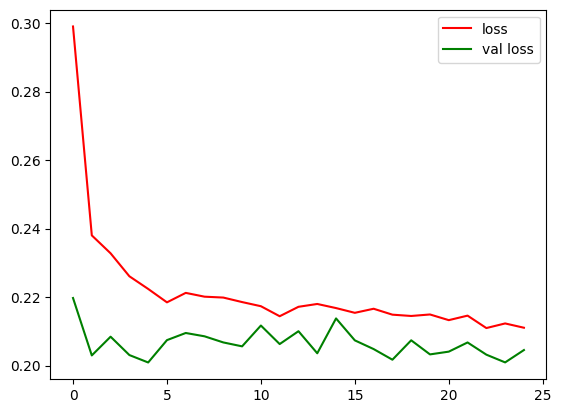

In [44]:
#print(model_history.history['loss'])
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')

plt.show()

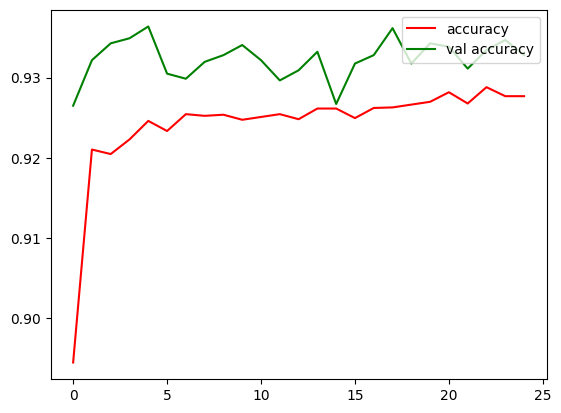

In [45]:
plt.plot(model_history.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(model_history.history['val_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [46]:
train_accuracy = model_history.history["accuracy"][-1]
train_auc = model_history.history["auc"][-1]
train_precision = model_history.history["precision"][-1]
train_recall = model_history.history["recall"][-1]
train_loss = model_history.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.9276863932609558
Train AUC: 0.8295882940292358
Train precision: 0.6239316463470459
Train recall: 0.13382218778133392
Train loss: 0.21104076504707336


In [47]:
validation_accuracy = model_history.history["val_accuracy"][-1]
validation_auc = model_history.history["val_auc"][-1]
validation_precision = model_history.history["val_precision"][-1]
validation_recall = model_history.history["val_recall"][-1]
validation_loss = model_history.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.932801365852356
Validation AUC: 0.8413814306259155
Validation precision: 0.84375
Validation recall: 0.14835165441036224
Validation loss: 0.2045242041349411


---
<a id="section62"></a>
# <font color="#004D7F" size=5> 6.2. Validation evaluation</font>

In [48]:
from sklearn.metrics import roc_auc_score
x_train_1 = [X_train_num, X_train_img]

def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_auc = 0
    best_thresh = 0
    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        auc = roc_auc_score(y_true, preds)
        if auc > best_auc:
            best_auc = auc
            best_thresh = thresh
    return best_thresh, best_auc
prediction = model.predict(x_train_1,)
best_threshold = find_best_threshold(y_train, prediction)
best_threshold ### !!!!!! IMPORTANTE PARA DEFINIR EL MEJOR CORTE PARA LAS PROBABILIDADES

/Users/manwest/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


(0.07, 0.7444190044442888)

In [49]:
#x_validacion = [X_test_num, X_test_img]
#y_validacion = y_test
x_validacion = [X_val_num, X_val_img]
y_validacion = y_val
score_test= model.evaluate(x_validacion, y_validacion)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9400 - auc: 0.8515 - fn: 140.9933 - fp: 5.4933 - loss: 0.1915 - precision: 0.8570 - recall: 0.2014 - tn: 2234.3533 - tp: 34.8667


In [50]:
X_train_num.shape

(14285, 6)

In [51]:
#test_images = next(test_iter)[0]
prediction = model.predict(x_validacion,)
#prediction = model.predict(test_images)
prediction_labels = (prediction > best_threshold[0]).astype(int)
#print(prediction_labels)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [52]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

test_accuracy = score_test[5]
test_auc = score_test[8]
test_precision = score_test[6]
test_recall = score_test[7]

print("Validation accuracy:",test_accuracy)
print("Validation AUC:",test_auc)
print("Validation precision:",test_precision)
print("Validation recall:",test_recall)

Validation accuracy: 0.9363712668418884
Validation AUC: 0.839516818523407
Validation precision: 0.8588235378265381
Validation recall: 0.20054945349693298


In [53]:
y_test1 = y_validacion.astype(float).astype(int)
y_test1

20134    0
5477     0
11396    0
128      1
4649     0
        ..
15036    0
11887    0
1596     0
8594     0
6684     0
Name: class, Length: 4762, dtype: int64

Test Dataset. 


Confusion matrix:


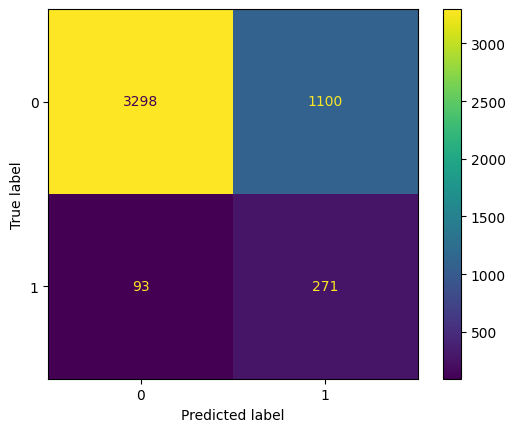

Verdaderos Negativos (VN): 3298
Falsos Positivos (FP): 1100
Falsos Negativos (FN): 93
Verdaderos Positivos (VP): 271 


AUC SCORE:
0.8399678425258235
Recall SCORE:
0.7445054945054945


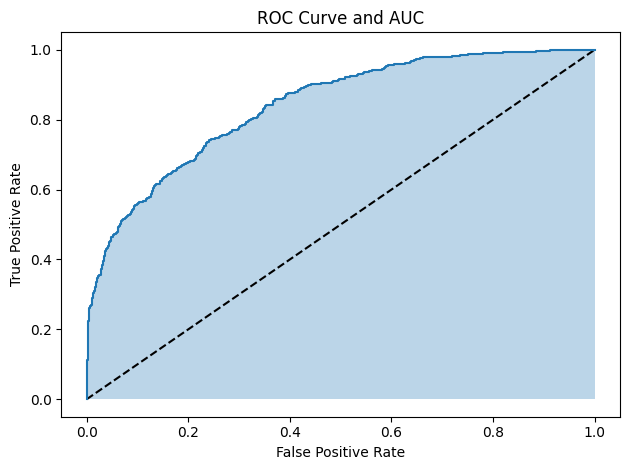

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, recall_score

# Suponiendo que ⁠ cnn_model ⁠ sea tu modelo entrenado y ⁠ X_test ⁠ tu conjunto de prueba
print("\033[1mTest Dataset.\033[0m \n\n")

# Confusion Matrix
print("\033[1mConfusion matrix:\033[0m")
cm = confusion_matrix(y_test1, prediction_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Verdaderos Negativos (VN): {cm[0, 0]}")
print(f"Falsos Positivos (FP): {cm[0, 1]}")
print(f"Falsos Negativos (FN): {cm[1, 0]}")
print(f"Verdaderos Positivos (VP): {cm[1, 1]} \n\n")

# Calcular las métricas usando probabilidades en lugar de etiquetas
#prediction_probs = model.predict([X_val_img])

print("\033[1mAUC SCORE:\033[0m")
print(roc_auc_score(y_test1, prediction ))

print("\033[1mRecall SCORE:\033[0m")
print(recall_score(y_test1, prediction_labels))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test1, prediction)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.tight_layout()
plt.show()

---
<a id="section63"></a>
# <font color="#004D7F" size=5> 6.3. Test evaluation</font>

In [55]:
x_validacion = [X_test_num, X_test_img]
y_validacion = y_test
#x_validacion = [X_val_num, X_val_img]
#y_validacion = y_val
score_test= model.evaluate(x_validacion, y_validacion)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9277 - auc: 0.8154 - fn: 151.3333 - fp: 13.4467 - loss: 0.2162 - precision: 0.6825 - recall: 0.1747 - tn: 2216.9666 - tp: 33.9600


In [56]:
#test_images = next(test_iter)[0]
prediction = model.predict(x_validacion,)
#prediction = model.predict(test_images)
prediction_labels = (prediction > best_threshold[0]).astype(int)
#print(prediction_labels)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [57]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

test_accuracy = score_test[5]
test_auc = score_test[8]
test_precision = score_test[6]
test_recall = score_test[7]

print("Test accuracy:",test_accuracy)
print("Test AUC:",test_auc)
print("Test precision:",test_precision)
print("Test recall:",test_recall)

Test accuracy: 0.9321713447570801
Test AUC: 0.8314940929412842
Test precision: 0.738095223903656
Test recall: 0.1707988977432251


In [58]:
y_test1 = y_validacion.astype(float).astype(int)
y_test1

17734    0
19878    0
19543    0
4964     0
3278     0
        ..
14449    0
5716     0
1307     0
9        1
19709    0
Name: class, Length: 4762, dtype: int64

Test Dataset. 


Confusion matrix:


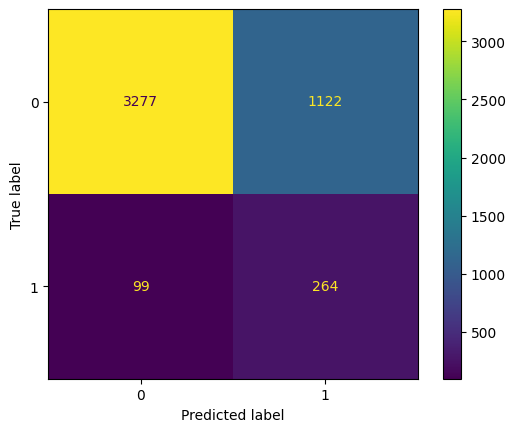

Verdaderos Negativos (VN): 3277
Falsos Positivos (FP): 1122
Falsos Negativos (FN): 99
Verdaderos Positivos (VP): 264 


AUC SCORE:
0.832113734839561
Recall SCORE:
0.7272727272727273


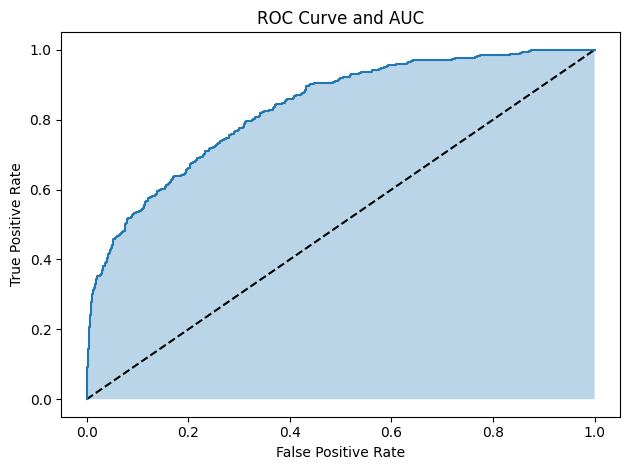

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, recall_score

# Suponiendo que ⁠ cnn_model ⁠ sea tu modelo entrenado y ⁠ X_test ⁠ tu conjunto de prueba
print("\033[1mTest Dataset.\033[0m \n\n")

# Confusion Matrix
print("\033[1mConfusion matrix:\033[0m")
cm = confusion_matrix(y_test1, prediction_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Verdaderos Negativos (VN): {cm[0, 0]}")
print(f"Falsos Positivos (FP): {cm[0, 1]}")
print(f"Falsos Negativos (FN): {cm[1, 0]}")
print(f"Verdaderos Positivos (VP): {cm[1, 1]} \n\n")

# Calcular las métricas usando probabilidades en lugar de etiquetas
#prediction_probs = model.predict([X_val_img])

print("\033[1mAUC SCORE:\033[0m")
print(roc_auc_score(y_test1, prediction ))

print("\033[1mRecall SCORE:\033[0m")
print(recall_score(y_test1, prediction_labels))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test1, prediction)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.tight_layout()
plt.show()